## Evaluate RAG Pipeline End-End

In [ ]:
# provide project root path
ProjectRoot = "/content/drive/MyDrive/UMich Capstone/NoteBooks/"
DatasetRoot = ProjectRoot + "Dataset/"

# DatasetRoot = "/content/drive/MyDrive/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Clear HuggingFace Cache

!du -hs ~/.cache/*
!rm -rf ~/.cache/huggingface

12K	/root/.cache/huggingface
36K	/root/.cache/matplotlib
7.2M	/root/.cache/node-gyp
2.0G	/root/.cache/pip


### Dependencies

In [2]:
try:
    import bert_score
except ImportError:
    !pip install bert_score
    import bert_score

try:
    from evaluate import load
except ImportError:
    !pip install evaluate

try:
    import rouge_score
except ImportError:
    !pip install rouge_score

try:
    import ragatouille
except ImportError:
    !pip install ragatouille

try:
    import einops
except ImportError:
    !pip install einops

try:
    import flash_attn
except ImportError:
    !pip install flash_attn

try:
    import outlines
except ImportError:
    !pip install outlines

  Using cached ragatouille-0.0.8.post2-py3-none-any.whl.metadata (15 kB)
  Using cached colbert-ai-0.2.19.tar.gz (86 kB)
  Preparing metadata (setup.py) ... done
  Using cached faiss_cpu-1.8.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.7 kB)
  Using cached fast_pytorch_kmeans-0.2.0.1-py3-none-any.whl.metadata (1.1 kB)
  Using cached langchain-0.1.20-py3-none-any.whl.metadata (13 kB)
  Using cached langchain_core-0.1.52-py3-none-any.whl.metadata (5.9 kB)
  Using cached llama_index-0.10.58-py3-none-any.whl.metadata (11 kB)
  Using cached onnx-1.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (16 kB)
  Using cached sentence_transformers-2.7.0-py3-none-any.whl.metadata (11 kB)
  Using cached voyager-2.0.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.9 kB)
  Using cached bitarray-2.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (34 kB)
  Using cached git_python-1.0.3-py2.py3-none-an

In [ ]:
import pandas as pd
import numpy as np
import json
import re

# LLM
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import T5ForConditionalGeneration, T5Tokenizer
from outlines import models, generate
from transformers import pipeline

# Information Retrieval (IR)
from ragatouille import RAGPretrainedModel

# evaluate
import bert_score
from evaluate import load
from tqdm.notebook import tqdm

# viz
import matplotlib.pyplot as plt
import seaborn as sns

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [ ]:
# load context and question test set which was created by doc2query
test_df = pd.read_csv(DatasetRoot + 'q_a_testset.csv')
if 'raw_para_id' not in test_df.columns:
  test_df['raw_para_id'] = test_df.index
test_df.head()

,raw_para_id,paragraph,question,Final_answer
0,0,data science is an interdisciplinary academic ...,what is data science?,Data science is an interdisciplinary academic ...
1,1,data science is multifaceted and can be descri...,what is data science?,Data science
2,2,"data science is a concept to unify statistics,...",How does data science change the world?,Data science is changing the world by introduc...
3,3,data scientist creates programming code and co...,"what's the meaning of ""data scientist"" in comp...",A data scientist in computer science is a prof...
4,4,the field includes preparing data for analysis...,Is data science a pure data science?,"No, data science is not a pure data science."


In [ ]:
# loading full article from json file
with open(DatasetRoot + 'raw_knowledge.json', 'r') as f:
    raw_text_json = json.load(f)
raw_text_list = [text for _, text in raw_text_json.items()]
# raw_text_list = raw_text_json

if not isinstance(raw_text_list, list):
    raise TypeError("Expected raw_text_list to be a list.")

In [ ]:
raw_df = pd.DataFrame(list(raw_text_json.items()), columns=['raw_para_id', 'raw_text'])
# raw_df = pd.DataFrame(list(enumerate(raw_text_list)), columns=['raw_para_id', 'raw_text'])
raw_df['raw_para_id'] = raw_df['raw_para_id'].astype('int64')
raw_df.head()

,raw_para_id,raw_text
0,0,Data science is an interdisciplinary academic ...
1,1,Data science also integrates domain knowledge ...
2,2,"Data science is ""a concept to unify statistics..."
3,3,A data scientist is a professional who creates...
4,4,Data science is an interdisciplinary field foc...


In [ ]:
# create dataframe of raw, summarized paragraphs and question
test_df = test_df.merge(raw_df, left_on='raw_para_id', right_on='raw_para_id', how='left')

In [ ]:
# dataframe holding metrics for different RAG models
RAGmodel_metrics_df = pd.DataFrame(columns=['Model', 'BERTScore_Precision', 'BERTScore_Recall', 'BERTScore_F1', 'METEOR', 'Rouge1', 'Rouge2', 'RougeL', 'RougeLsum'])

In [ ]:
if torch.cuda.is_available():
    torch.set_default_device("cuda")
    print("CUDA is available!!")
else:
    raise RuntimeError("CUDA is not available!! LLM cannot run, rerun with GPU")

RuntimeError: CUDA is not available!! LLM cannot run, rerun with GPU

### Helper Methods

In [ ]:
def calculate_metrics(metrics_df, model_name, candidate_answers, true_answers):
    # Calculate BERTScore
    # bert_metrics = bert_score.score(cands=candidate_answers, refs=true_answers, model_type='roberta-large', nthreads=4)
    bert_metrics = bert_score.score(cands=candidate_answers, refs=true_answers, model_type='bert-base-uncased', nthreads=4)

    # Fetch precision, recall, F1 score from BERT score (https://lightning.ai/docs/torchmetrics/stable/text/bert_score.html)
    BERTScore_Precision = np.mean(np.array(bert_metrics[0]))
    BERTScore_Recall = np.mean(np.array(bert_metrics[1]))
    BERTScore_F1 =  np.mean(np.array(bert_metrics[2]))
    print(f"BERTScore Precision: {BERTScore_Precision}")
    print(f"BERTScore Recall: {BERTScore_Recall}")
    print(f"BERTScore F1 Score: {BERTScore_F1}")

    # calculate meteor via https://huggingface.co/spaces/evaluate-metric/meteor
    meteor = load('meteor')
    Meteor_score = meteor.compute(predictions=candidate_answers, references=true_answers)
    Meteor_score = Meteor_score['meteor']
    print(f"METEOR Score: {Meteor_score}")

    # calculate rouge via https://huggingface.co/spaces/evaluate-metric/rouge
    rouge = load("rouge")
    rouge_score = rouge.compute(predictions=candidate_answers, references=true_answers)
    print(f"ROUGE Score: {rouge_score}")
    Rouge1  = rouge_score['rouge1']
    Rouge2  = rouge_score['rouge2']
    RougeL  = rouge_score['rougeL']
    RougeLsum = rouge_score['rougeLsum']

    # record results
    new_row = pd.DataFrame({
        'Model': [model_name],
        'BERTScore_Precision': [BERTScore_Precision],
        'BERTScore_Recall': [BERTScore_Recall],
        'BERTScore_F1': [BERTScore_F1],
        'METEOR': [Meteor_score],
        'Rouge1': [Rouge1],
        'Rouge2': [Rouge2],
        'RougeL': [RougeL],
        'RougeLsum': [RougeLsum]
    })

    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

    return metrics_df

In [ ]:
def FreeGPUMem(model, tokenizer):
    import gc

    del model
    del tokenizer
    gc.collect()
    torch.cuda.empty_cache()

### Initialize Retriever

In [ ]:
retriever = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
index_path = retriever.index(index_name="knowledgestore_index", collection=raw_text_list)
retriever = RAGPretrainedModel.from_index(index_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[Jul 30, 07:18:29] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Jul 30, 07:19:31] #> Creating directory .ragatouille/colbert/indexes/knowledgestore_index 


[Jul 30, 07:19:32] [0] 		 #> Encoding 24 passages..


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 1/1 [00:17<00:00, 17.74s/it]

[Jul 30, 07:19:50] [0] 		 avg_doclen_est = 73.54166412353516 	 len(local_sample) = 24
[Jul 30, 07:19:50] [0] 		 Creating 512 partitions.
[Jul 30, 07:19:50] [0] 		 *Estimated* 1,764 embeddings.
[Jul 30, 07:19:50] [0] 		 #> Saving the indexing plan to .ragatouille/colbert/indexes/knowledgestore_index/plan.json ..


used 8 iterations (0.2193s) to cluster 1677 items into 512 clusters
[0.03, 0.029, 0.028, 0.028, 0.029, 0.031, 0.026, 0.028, 0.026, 0.026, 0.024, 0.027, 0.03, 0.034, 0.031, 0.031, 0.027, 0.029, 0.026, 0.026, 0.023, 0.03, 0.03, 0.029, 0.03, 0.03, 0.035, 0.03, 0.029, 0.03, 0.024, 0.028, 0.036, 0.027, 0.028, 0.026, 0.037, 0.025, 0.026, 0.026, 0.03, 0.023, 0.026, 0.029, 0.027, 0.025, 0.028, 0.03, 0.036, 0.027, 0.033, 0.025, 0.03, 0.024, 0.029, 0.035, 0.029, 0.033, 0.028, 0.027, 0.028, 0.03, 0.028, 0.03, 0.032, 0.03, 0.032, 0.029, 0.023, 0.027, 0.031, 0.027, 0.03, 0.031, 0.032, 0.028, 0.031, 0.031, 0.026, 0.034, 0.03, 0.035, 0.029, 0.028, 0.033, 0.03, 0.029, 0.029, 0.03, 0.035, 0.03, 0.029, 0.029, 0.028, 0.029, 0.027, 0.036, 0.031, 0.027, 0.028, 0.029, 0.032, 0.033, 0.031, 0.034, 0.031, 0.025, 0.031, 0.032, 0.03, 0.031, 0.03, 0.033, 0.024, 0.024, 0.024, 0.026, 0.029, 0.029, 0.033, 0.025, 0.033, 0.024, 0.031, 0.027, 0.029, 0.033, 0.034]


0it [00:00, ?it/s]

[Jul 30, 07:19:50] [0] 		 #> Encoding 24 passages..



100%|██████████| 1/1 [00:18<00:00, 18.47s/it]
1it [00:18, 18.56s/it]
100%|██████████| 1/1 [00:00<00:00, 727.04it/s]

[Jul 30, 07:20:09] #> Optimizing IVF to store map from centroids to list of pids..
[Jul 30, 07:20:09] #> Building the emb2pid mapping..
[Jul 30, 07:20:09] len(emb2pid) = 1765



100%|██████████| 512/512 [00:00<00:00, 17626.31it/s]

[Jul 30, 07:20:09] #> Saved optimized IVF to .ragatouille/colbert/indexes/knowledgestore_index/ivf.pid.pt


Done indexing!


### Evaluate Microsoft/Phi-3

In [ ]:
# model_name = "microsoft/phi-2"
model_name = "microsoft/Phi-3-mini-4k-instruct"
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

In [ ]:
# Guided decoding
from pydantic import BaseModel
class Response(BaseModel):
    explanation: str
    response: str

outlines_model = models.Transformers(model, tokenizer)
outlines_generator = generate.json(outlines_model, Response)

In [ ]:
def generate_prompt_fewshot(context, question):
    prompt_template = """
You are an expert in understanding and interpreting provided text contexts. Given a context and a question, your task is to generate an accurate and informative answer based on the provided context. Here is the structure:

1. **Context:** The detailed text or passage that contains the information needed to answer the question.
2. **Question:** A specific question that needs to be answered based on the context.

Please make sure your response is clear, concise, and directly addresses the question. If the context does not contain sufficient information to answer the question, say I don't know.

**Context:**
{context}

**Question:**
{question}

The response is a valid JSON with fields `explanation` and `response`.
"""
    return prompt_template.format(context=context, question=question)


# # LLM inference wrapper
# def AskLLM(context, question):
#     prompt = generate_prompt_fewshot(context, question)

#     inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True)

#     # Ask LLM to answer
#     outputs = model.generate(**inputs, max_length=600)
#     text = tokenizer.batch_decode(outputs)[0]


#     # Regular expression to extract the Final Answer
#     answer_pattern = r"\*\*Final Answer:\*\*\s*(.*)<|endoftext|>"
#     answer_pattern = r"\*\*Final Answer:\*\*\s*(.*)"

#     # Extract answer from LLM response
#     match = re.search(answer_pattern, text, re.DOTALL)
#     final_answer = ""
#     if match:
#         final_answer = match.group(1).strip()
#     else:
#         print("Final Answer not found !!!")

#     print('>='*20)
#     print(final_answer)
#     return final_answer


# LLM inference wrapper
def AskLLM(context, question):
    prompt = generate_prompt_fewshot(context, question)
    response = outlines_generator(prompt)
    final_answer = response.response
    print('>='*20)
    print(final_answer)
    return final_answer

# RAG Pipeline
def AskRAG(question):
    # get top relevant doc
    retrieved_doc = retriever.search(question, k=1)
    # pass context and query to get answer
    return AskLLM(retrieved_doc[0]['content'], question)


In [ ]:
candidate_answers = []
true_answers = []

for _, eval_data in tqdm(test_df.iterrows()):
    question = eval_data.question

    true_answers.append(eval_data.Final_answer)
    candidate_answers.append(AskRAG(question))


#### Calculate Different metric scores

In [ ]:
RAGmodel_metrics_df = calculate_metrics(metrics_df = RAGmodel_metrics_df, model_name = "Microsoft/Phi-3", candidate_answers = candidate_answers, true_answers = true_answers)

### Evaluate Microsoft/Phi-2

In [ ]:
FreeGPUMem(model, tokenizer)

In [ ]:
model_name = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

In [ ]:
def generate_prompt_fewshot(context, question):
    prompt_template = """
You are an expert in understanding and interpreting provided text contexts. Given a context and a question, your task is to generate an accurate and informative answer based on the provided context. Here is the structure:

1. **Context:** The detailed text or passage that contains the information needed to answer the question.
2. **Question:** A specific question that needs to be answered based on the context.

Please make sure your response is clear, concise, and directly addresses the question. If the context does not contain sufficient information to answer the question, say I don't know.

**Example:**

**Context:**
"The rainforests of the Amazon are home to a vast diversity of species, including numerous plants, animals, and insects. These forests play a crucial role in regulating the Earth's climate by absorbing carbon dioxide and releasing oxygen. However, deforestation poses a significant threat to these ecosystems, leading to loss of habitat and biodiversity."

**Question:**
"Why are the rainforests of the Amazon important for the Earth's climate?"

**Answer:**
"The rainforests of the Amazon are important for the Earth's climate because they absorb carbon dioxide and release oxygen, helping to regulate the climate."

Please follow this format for each question:

**Context:**
{context}

**Question:**
{question}

**Final Answer:**
"""
    return prompt_template.format(context=context, question=question)

In [ ]:
# LLM inference wrapper
def AskLLM(context, question):
    prompt = generate_prompt_fewshot(context, question)

    inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True)

    # Ask LLM to answer
    outputs = model.generate(**inputs, max_length=500)
    text = tokenizer.batch_decode(outputs)[0]

    # Regular expression to extract the Final Answer
    answer_pattern = r"\*\*Final Answer:\*\*\s*(.*)<|endoftext|>"

    # Extract answer from LLM response
    match = re.search(answer_pattern, text, re.DOTALL)
    final_answer = ""
    if match:
        final_answer = match.group(1).strip()
        # print("Final Answer:", final_answer)
    else:
        print("Final Answer not found !!!")

    return final_answer

# RAG Pipeline
def AskRAG(question):
    # get top relevant doc
    retrieved_doc = retriever.search(question, k=1)
    # pass context and query to get answer
    return AskLLM(retrieved_doc[0]['content'], question)

In [ ]:
candidate_answers = []
true_answers = []

for _, eval_data in tqdm(test_df.iterrows()):
    question = eval_data.question

    true_answers.append(eval_data.Final_answer)
    candidate_answers.append(AskRAG(question))

#### Calculate Different metric scores

In [ ]:
RAGmodel_metrics_df = calculate_metrics(metrics_df = RAGmodel_metrics_df, model_name = "Microsoft/Phi-2", candidate_answers = candidate_answers, true_answers = true_answers)

### Evaluate Qwen/Qwen2-1.5B-Instruct

In [ ]:
FreeGPUMem(model, tokenizer)

In [ ]:
model_name = "Qwen/Qwen2-1.5B-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

In [ ]:
def generate_prompt(context, question):
    prompt_template = """
You are an expert in understanding and interpreting provided text contexts. Given a context and a question, your task is to generate an accurate and informative answer based on the provided context. Here is the structure:

1. **Context:** The detailed text or passage that contains the information needed to answer the question.
2. **Question:** A specific question that needs to be answered based on the context.

Please make sure your response is clear, concise, and directly addresses the question. If the context does not contain sufficient information to answer the question, say I don't know.

**Context:**
{context}

**Question:**
{question}

The response is a valid JSON with fields `explanation` and `response`.
"""
    return prompt_template.format(context=context, question=question)

In [ ]:
# LLM inference wrapper
def AskLLM(context, question):
    prompt = generate_prompt(context, question)

    inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True)

    # Ask LLM to answer
    outputs = model.generate(**inputs, max_length=500)
    text = tokenizer.batch_decode(outputs)[0]

    # Extract the answer
    json_match = re.search(r'{.*}', answer, re.DOTALL)

    if json_match:
        # extract and parse JSON
        json_string = json_match.group(0)
        response_dict = json.loads(json_string)
        final_answer = response_dict['response']
    else:
        final_answer = "I don't know."

    return final_answer

# RAG Pipeline
def AskRAG(question):
    # get top relevant doc
    retrieved_doc = retriever.search(question, k=1)
    # pass context and query to get answer
    return AskLLM(retrieved_doc[0]['content'], question)

In [ ]:
candidate_answers = []
true_answers = []

for _, eval_data in tqdm(test_df.iterrows()):
    question = eval_data.question

    true_answers.append(eval_data.Final_answer)
    candidate_answers.append(AskRAG(question))

#### Calculate Different metric scores

In [ ]:
RAGmodel_metrics_df = calculate_metrics(metrics_df = RAGmodel_metrics_df, model_name = "Qwen/Qwen2-1.5B-Instruct", candidate_answers = candidate_answers, true_answers = true_answers)

### Evaluate google/flan-t5-large

In [ ]:
model_name = "google/flan-t5-large"
model = T5ForConditionalGeneration.from_pretrained(model_name, torch_dtype="auto", trust_remote_code=True)
tokenizer = T5Tokenizer.from_pretrained(model_name, trust_remote_code=True)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def generate_prompt(context, query):
    prompt = f"""Give the answer to the user query delimited by triple backticks ```{query}```
                using the information given in context delimited by triple backticks ```{context}```.
                If there is no relevant information in the provided context, tell user that you did not have any relevant context to base your answer on. Be concise and output the answer.
                """
    return prompt

In [ ]:
# LLM inference wrapper
def AskLLM(context, question):
    prompt = generate_prompt(context, question)

    inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True)

    # Ask LLM to answer
    outputs = model.generate(**inputs, max_length=500)
    final_answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return final_answer

# RAG Pipeline
def AskRAG(question):
    # get top relevant doc
    retrieved_doc = retriever.search(question, k=1)
    # pass context and query to get answer
    return AskLLM(retrieved_doc[0]['content'], question)

In [ ]:
candidate_answers = []
true_answers = []

for _, eval_data in tqdm(test_df.iterrows()):
    question = eval_data.question

    true_answers.append(eval_data.Final_answer)
    candidate_answers.append(AskRAG(question))

0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


#### Calculate Different metric scores

In [ ]:
RAGmodel_metrics_df = calculate_metrics(metrics_df = RAGmodel_metrics_df, model_name = "google/flan-t5-large", candidate_answers = candidate_answers, true_answers = true_answers)

BERTScore Precision: 0.6262633204460144
BERTScore Recall: 0.6694580912590027
BERTScore F1 Score: 0.6411857008934021


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: 0.33362887030621374
ROUGE Score: {'rouge1': 0.41281192825832314, 'rouge2': 0.19905297026373045, 'rougeL': 0.3787793579658727, 'rougeLsum': 0.3833143176577235}


### Evaluate distilbert/distilbert-base-cased-distilled-squad

In [ ]:
model = pipeline("question-answering", model='distilbert-base-cased-distilled-squad')

In [ ]:
# LLM inference wrapper
def AskLLM(context, question):
    answer = model(question=question, context=context)
    final_answer = answer['answer']
    return final_answer

# RAG Pipeline
def AskRAG(question):
    # get top relevant doc
    retrieved_doc = retriever.search(question, k=1)
    # pass context and query to get answer
    return AskLLM(retrieved_doc[0]['content'], question)

In [ ]:
candidate_answers = []
true_answers = []

for _, eval_data in tqdm(test_df.iterrows()):
    question = eval_data.question

    true_answers.append(eval_data.Final_answer)
    candidate_answers.append(AskRAG(question))

0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


#### Calculate Different metric scores

In [ ]:
RAGmodel_metrics_df = calculate_metrics(metrics_df = RAGmodel_metrics_df, model_name = "distilbert/distilbert-base-cased-distilled-squad", candidate_answers = candidate_answers, true_answers = true_answers)

BERTScore Precision: 0.5959429740905762
BERTScore Recall: 0.5001112818717957
BERTScore F1 Score: 0.5334399342536926


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: 0.15130187384430172
ROUGE Score: {'rouge1': 0.23284858344742448, 'rouge2': 0.09681366654405871, 'rougeL': 0.226957345281513, 'rougeLsum': 0.22867076085586735}


### Evaluate deepset/roberta-base-squad2-distilled

In [ ]:
model = pipeline("question-answering", model='deepset/roberta-base-squad2-distilled')

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/295 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
# LLM inference wrapper
def AskLLM(context, question):
    answer = model(question=question, context=context)
    final_answer = answer['answer']
    return final_answer

# RAG Pipeline
def AskRAG(question):
    # get top relevant doc
    retrieved_doc = retriever.search(question, k=1)
    # pass context and query to get answer
    return AskLLM(retrieved_doc[0]['content'], question)

In [ ]:
candidate_answers = []
true_answers = []

for _, eval_data in tqdm(test_df.iterrows()):
    question = eval_data.question

    true_answers.append(eval_data.Final_answer)
    candidate_answers.append(AskRAG(question))

0it [00:00, ?it/s]

#### Calculate Different metric scores

In [ ]:
RAGmodel_metrics_df = calculate_metrics(metrics_df = RAGmodel_metrics_df, model_name = "deepset/roberta-base-squad2-distilled", candidate_answers = candidate_answers, true_answers = true_answers)

BERTScore Precision: 0.6136068105697632
BERTScore Recall: 0.5181886553764343
BERTScore F1 Score: 0.5538690090179443


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: 0.17828206065896338
ROUGE Score: {'rouge1': 0.29074494607389345, 'rouge2': 0.09505104126358288, 'rougeL': 0.2709138816704606, 'rougeLsum': 0.2787011731913047}


### Compare Models

In [ ]:
RAGmodel_metrics_df

,Model,BERTScore_Precision,BERTScore_Recall,BERTScore_F1,METEOR,Rouge1,Rouge2,RougeL,RougeLsum
0,distilbert/distilbert-base-cased-distilled-squad,0.595943,0.500111,0.533440,0.151302,0.232849,0.096814,0.226957,0.228671
1,deepset/roberta-base-squad2-distilled,0.613607,0.518189,0.553869,0.178282,0.290745,0.095051,0.270914,0.278701
2,google/flan-t5-large,0.626263,0.669458,0.641186,0.333629,0.412812,0.199053,0.378779,0.383314


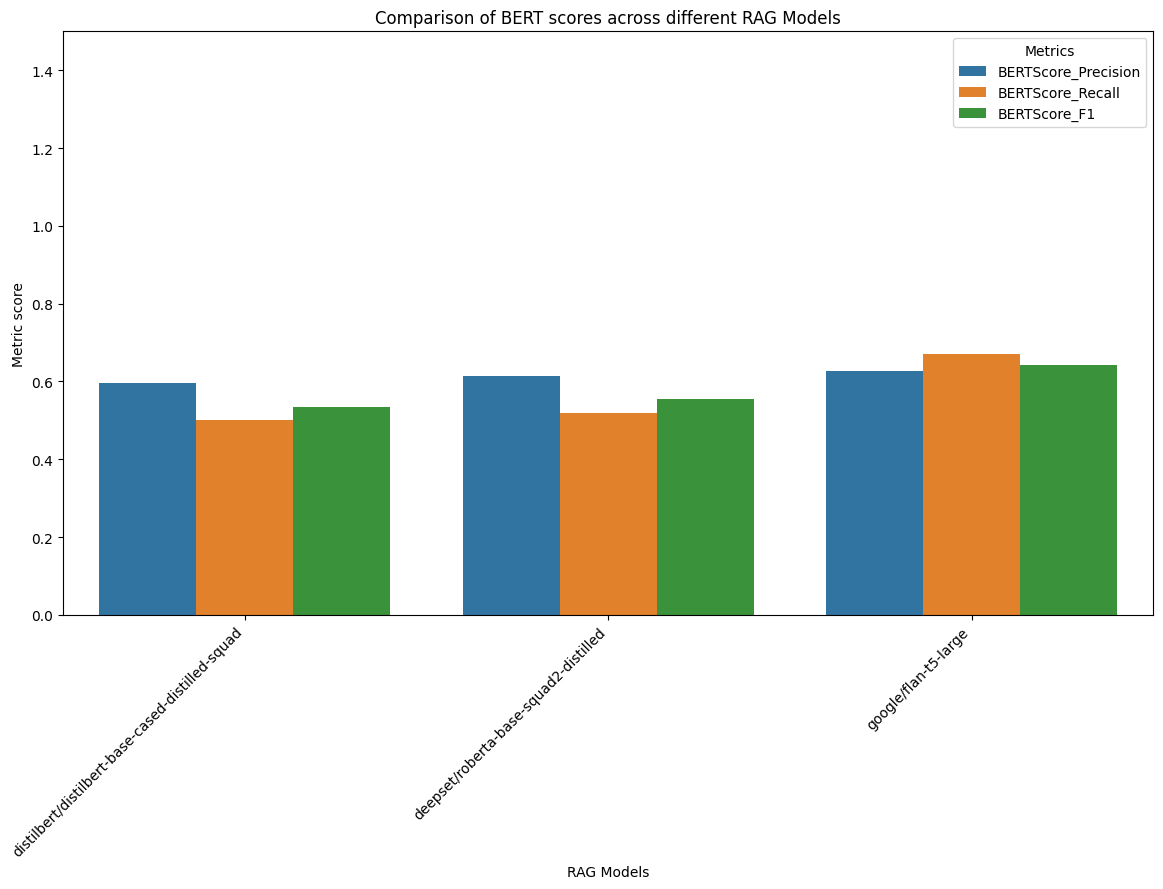

In [ ]:
# melt df to plot BERT score based Precision, Recall, F1
melted_df = RAGmodel_metrics_df[['Model', 'BERTScore_Precision', 'BERTScore_Recall', 'BERTScore_F1']].melt(id_vars='Model', var_name='Metric', value_name='Value')

# Plot
plt.figure(figsize=(12, 9))
sns.barplot(data=melted_df, x='Model', y='Value', hue='Metric')
plt.title('Comparison of BERT scores across different RAG Models')
plt.xticks(rotation=45, ha='right')
plt.xlabel('RAG Models')
plt.ylabel('Metric score')
plt.ylim(0.0, 1.5)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

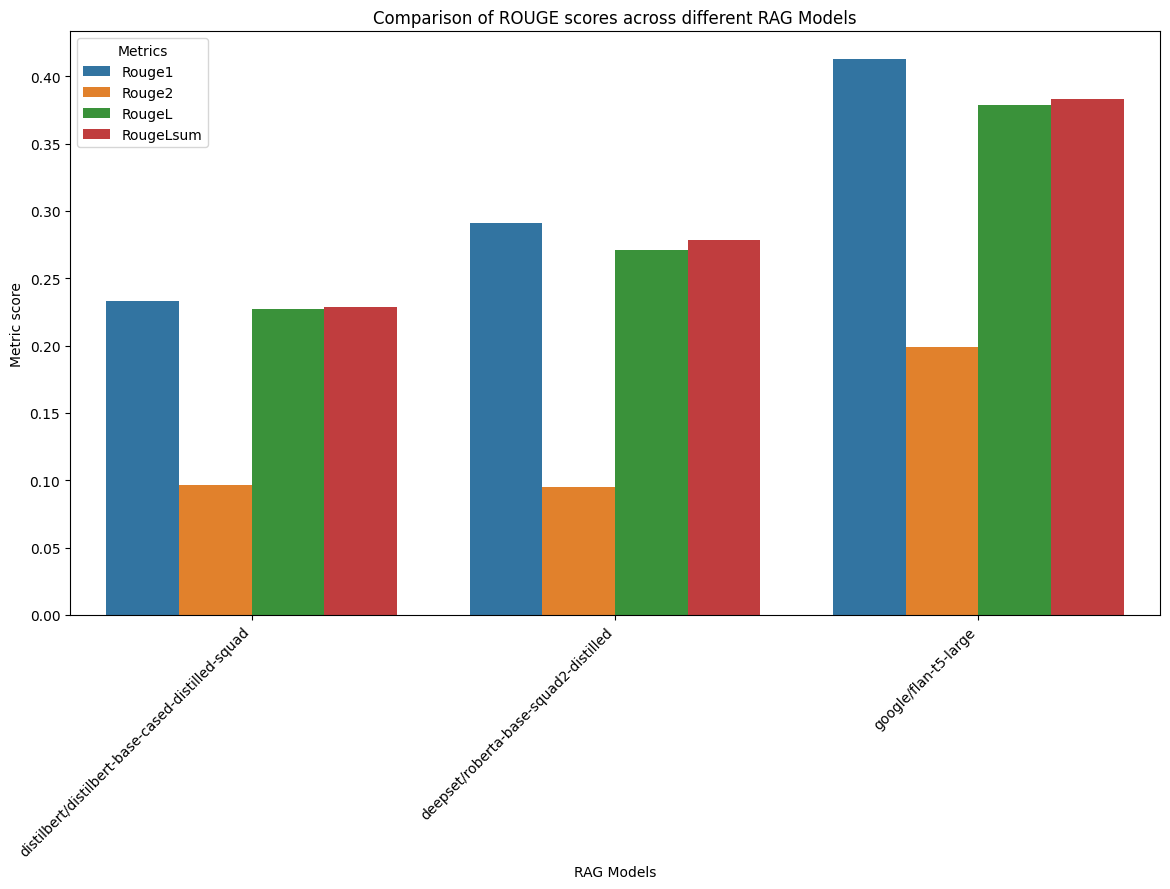

In [ ]:
# melt df to plot ROUGE scores
melted_df = RAGmodel_metrics_df[['Model', 'Rouge1', 'Rouge2', 'RougeL', 'RougeLsum']].melt(id_vars='Model', var_name='Metric', value_name='Value')

# Plot
plt.figure(figsize=(12, 9))
sns.barplot(data=melted_df, x='Model', y='Value', hue='Metric')
plt.title('Comparison of ROUGE scores across different RAG Models')
plt.xticks(rotation=45, ha='right')
plt.xlabel('RAG Models')
plt.ylabel('Metric score')
#plt.ylim(0.0, 1.5)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

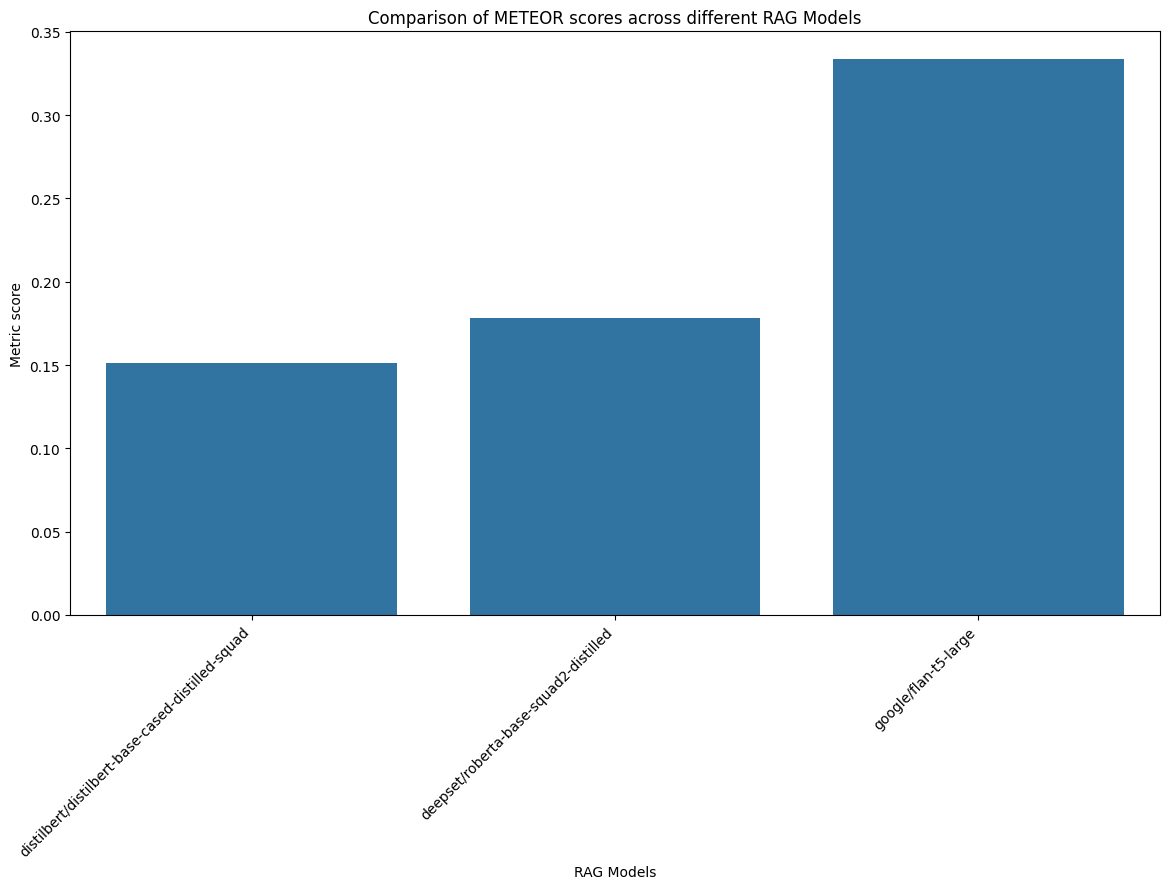

In [ ]:
# Plot METEOR scores
plt.figure(figsize=(12, 9))
sns.barplot(data=RAGmodel_metrics_df, x='Model', y='METEOR')
plt.title('Comparison of METEOR scores across different RAG Models')
plt.xticks(rotation=45, ha='right')
plt.xlabel('RAG Models')
plt.ylabel('Metric score')
#plt.ylim(0.0, 1.5)
plt.tight_layout()
plt.show()